In [2]:
%%bash
apt-get install graphviz
pip install graphviz pydot

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
# -*- coding: utf-8 -*-
# Author : Ali Mirzaei
# Date : 19/09/2017
# URL: https://github.com/alimirzaei/adverserial-autoencoder-keras/blob/master/AAE.py

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import CSVLogger


from tqdm import tqdm
import numpy as np
import matplotlib

matplotlib.use('Agg')

import matplotlib.pyplot as plt
from IPython.display import SVG

plt.ioff()

In [0]:
class AAN():
    def __init__(self, img_shape=(28, 28), encoded_dim=2):
        self.model_names = [
            "autoencoder",
            "discriminator",
            "encoder_discriminator"
        ]
        self.encoded_dim = encoded_dim
        self.optimizer_reconst = Adam(0.01)
        self.optimizer_discriminator = Adam(0.01)
        self.initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)
        self._initAndCompileFullModel(img_shape, encoded_dim)
        self.plot_models()
        

    def _genEncoderModel(self, img_shape, encoded_dim):
        """ Build Encoder Model Based on Paper Configuration
        Args:
            img_shape (tuple) : shape of input image
            encoded_dim (int) : number of latent variables
        Return:
            A sequential keras model
        """
        model_key="encoder"
        encoder = Sequential([
            Flatten(input_shape=img_shape, name=f"{model_key}_input"),
            Dense(
                1000, activation='relu',
                kernel_initializer=self.initializer,
                bias_initializer=self.initializer,
                name=f"{model_key}_dense_1"
            ),
            Dense(
                1000, activation='relu',
                kernel_initializer=self.initializer,
                bias_initializer=self.initializer,
                name=f"{model_key}_dense_2"
            ),
            Dense(
                encoded_dim, 
                kernel_initializer=self.initializer,
                bias_initializer=self.initializer,
                name=f"{model_key}_z"
            )
        ], name=model_key)
        encoder.summary()
        return encoder

    def _getDecoderModel(self, encoded_dim, img_shape):
        """ Build Decoder Model Based on Paper Configuration
        Args:
            encoded_dim (int) : number of latent variables
            img_shape (tuple) : shape of target images
        Return:
            A sequential keras model
        """
        model_key="decoder"
        decoder = Sequential([
            Dense(
                1000, activation='relu',
                input_dim=encoded_dim, 
                kernel_initializer=self.initializer,
                bias_initializer=self.initializer,
                name=f"{model_key}_dense_1"
            ),
            Dense(
                1000, activation='relu',
                kernel_initializer=self.initializer,
                bias_initializer=self.initializer,
                name=f"{model_key}_dense_2"
            ),
            Dense(
                np.prod(img_shape), 
                activation='sigmoid', 
                kernel_initializer=self.initializer,
                bias_initializer=self.initializer,
                name=f"{model_key}_sigmoid"
            ),
            Reshape(img_shape, name=f"{model_key}_reshape")
        ], name=model_key)
        decoder.summary()
        return decoder

    def _getDescriminator(self, encoded_dim):
        """ Build Descriminator Model Based on Paper Configuration
        Args:
            encoded_dim (int) : number of latent variables
        Return:
            A sequential keras model
        """
        model_key="discriminator"
        discriminator = Sequential([
            Dense(
                1000, activation='relu',
                input_dim=encoded_dim, 
                kernel_initializer=self.initializer,
                bias_initializer=self.initializer,
                name=f"{model_key}_dense_1"
            ),
            Dense(
                1000, activation='relu',
                kernel_initializer=self.initializer,
                bias_initializer=self.initializer,
                name=f"{model_key}_dense_2"
            ),
            Dense(
                1, activation='sigmoid', 
                kernel_initializer=self.initializer,
                bias_initializer=self.initializer,
                name=f"{model_key}_sigmoid"
            )
        ], name=model_key)
        discriminator.summary()
        return discriminator

    def _initAndCompileFullModel(self, img_shape, encoded_dim):
        self.encoder = self._genEncoderModel(img_shape, encoded_dim)
        self.decoder = self._getDecoderModel(encoded_dim, img_shape)
        self.discriminator_model = self._getDescriminator(encoded_dim)
        img = Input(shape=img_shape, name="image_input")
        encoded_repr = self.encoder(img)
        gen_img = self.decoder(encoded_repr)
        self.autoencoder = Model(img, gen_img, name="autoencoder")
        valid = self.discriminator_model(encoded_repr)
        self.encoder_discriminator = Model(img, valid, name="encoder_discriminator")
        z_input = Input(shape=(encoded_dim,), name="discriminator_z_input")
        discriminator_output = self.discriminator_model(z_input)
        self.discriminator = Model(z_input, discriminator_output, name="discriminator")
        self.discriminator.compile(optimizer=self.optimizer_discriminator,
                                   loss='binary_crossentropy',
                                   metrics=['accuracy'])
        self.autoencoder.compile(optimizer=self.optimizer_reconst,
                                 loss ='mse')
        for layer in self.discriminator.layers:
            layer.trainable = False
        self.encoder_discriminator.compile(optimizer=self.optimizer_discriminator,
                                           loss='binary_crossentropy',
                                           metrics=['accuracy'])
    def plot_models(self):
        for name, model in zip(
            self.model_names, [
            self.autoencoder, 
            self.discriminator,
            self.encoder_discriminator
        ]):
            model.summary()
            plot_model(
                model,
                to_file=f'{name}.png',
                show_shapes=True,
                show_layer_names=True,
                rankdir='TB'
            )
    
    def imagegrid(self, epochnumber):
        fig = plt.figure(figsize=[20, 20])
        images = self.generateImages(100)
        for index,img in enumerate(images):
            img = img.reshape((28, 28))
            ax = fig.add_subplot(10, 10, index+1)
            ax.set_axis_off()
            ax.imshow(img, cmap="gray")
        fig.savefig("images/AAE/"+str(epochnumber)+".png")
        plt.show()
        plt.close(fig)
    def generateImages(self, n=100):
        latents = 5*np.random.normal(size=(n, self.encoded_dim))
        imgs = self.decoder.predict(latents)
        return imgs
      
    def create_callbacks(self):
        self.callbacks = {}
        for name, model in zip(
            self.model_names, [
            self.autoencoder, 
            self.discriminator,
            self.encoder_discriminator
        ]):
            csv_callback = CSVLogger(f"{name}_log.csv", separator="\t")
            csv_callback.set_model(model)
            model.stop_training = False
            self.callbacks[name] = csv_callback
            

    def train(self, x_train, batch_size=100, epochs=5000, save_interval=500):
        self.create_callbacks()
        half_batch = int(batch_size / 2)
        with tqdm(total=epochs, desc="Epoch: ") as pbar:
            for epoch in range(epochs):
                pbar.set_description(f"Epoch {epoch:5d}")
                epoch_metrics = {}
                #---------------Train Discriminator -------------
                # Select a random half batch of images
                idx = np.random.randint(0, x_train.shape[0], half_batch)
                imgs = x_train[idx]
                # Generate a half batch of new images
                latent_fake = self.encoder.predict(imgs)
                #gen_imgs = self.decoder.predict(latent_fake)
                latent_real = 5*np.random.normal(size=(half_batch, self.encoded_dim))
                valid = np.ones((half_batch, 1))
                fake = np.zeros((half_batch, 1))
                # Train the discriminator
                d_loss_real, d_loss_real_acc = self.discriminator.train_on_batch(latent_real, valid)
                d_loss_fake, d_loss_fake_acc = self.discriminator.train_on_batch(latent_fake, fake)
                d_loss = 0.5 * (d_loss_real+d_loss_fake)
                d_acc = 0.5 * (d_loss_real_acc+d_loss_fake_acc)
                d_metrics = {
                    "d_loss_real": d_loss_real,
                    "d_loss_fake": d_loss_fake,
                    "d_loss": d_loss,
                    "d_loss_real_acc": d_loss_real_acc,
                    "d_loss_fake_acc": d_loss_fake_acc,
                    "d_acc": d_acc                    
                }
                #self.callbacks["discriminator"].on_epoch_end(epoch, d_metrics)
                epoch_metrics.update(d_metrics)
                idx = np.random.randint(0, x_train.shape[0], batch_size)
                imgs = x_train[idx]
                # Generator wants the discriminator to label the generated representations as valid
                valid_y = np.ones((batch_size, 1))

                # Train the autoencode reconstruction
                ae_loss_reconstruction = self.autoencoder.train_on_batch(imgs, imgs)
                ae_metrics = {
                    "ae_loss": ae_loss_reconstruction
                }
                #self.callbacks["autoencoder"].on_epoch_end(epoch, ae_metrics)
                epoch_metrics.update(ae_metrics)

                # Train generator
                g_loss_ce, g_acc = self.encoder_discriminator.train_on_batch(imgs, valid_y)
                g_metrics = {
                    "g_loss_ce": g_loss_ce,
                    "g_acc": g_acc
                }
                #self.callbacks["encoder_discriminator"].on_epoch_end(epoch, g_metrics)
                epoch_metrics.update(g_metrics)
                # Plot the progress                
                pbar.set_postfix(**epoch_metrics)
                pbar.update(1)
                if(epoch % save_interval == 0):
                    self.imagegrid(epoch)
        for name, csv_callback in self.callbacks.items():
            #csv_callback.on_train_end()
            pass

In [3]:
K.clear_session()
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.
ann = AAN(encoded_dim=8)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (Flatten)      (None, 784)               0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 1000)              785000    
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 1000)              1001000   
_________________________________________________________________
encoder_z (Dense)            (None, 8)                 8008      
Total params: 1,794,008
Trainable params: 1,794,008
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_dense_1 (Dense)      (None, 1000)              9000 

In [4]:
! rm ./images/AAE/*
ann.train(x_train)

Epoch     0:   0%|          | 0/5000 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


Epoch  4999: 100%|██████████| 5000/5000 [03:04<00:00, 31.15it/s, ae_loss=0.0575, d_acc=0.5, d_loss=7.97, d_loss_fake=15.9, d_loss_fake_acc=0, d_loss_real=1.19e-7, d_loss_real_acc=1, g_acc=1, g_loss_ce=1.19e-7]


## Plot embedding space

In [0]:
%matplotlib inline

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
sns.set_context("talk")
sns.set_style("ticks")

In [14]:
train_embeddings = ann.encoder.predict(x_train)
test_embeddings = ann.encoder.predict(x_test)
train_embeddings.shape, test_embeddings.shape

((60000, 8), (10000, 8))

In [0]:
pca = PCA(n_components=2)
pca_train = pca.fit_transform(train_embeddings)
pca_test = pca.transform(test_embeddings)

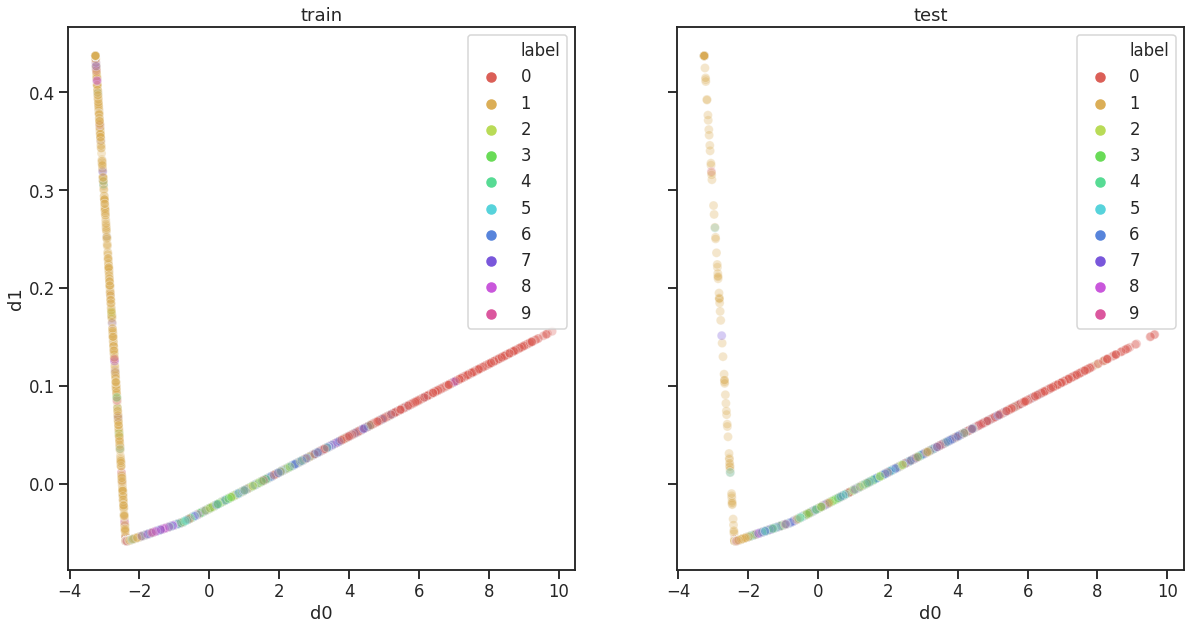

In [17]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 10))
for axi, title, pca_output, y in zip(
    ax, ["train", "test"], [pca_train, pca_test], [y_train, y_test]
): 
  sns.scatterplot(
      x="d0", y="d1",
      hue="label",
      palette=sns.color_palette("hls", 10),
      data=pd.DataFrame({
          "d0": pca_output[:, 0],
          "d1": pca_output[:, 1],
          "label": y
      }),
      legend="full",
      alpha=0.3,
      ax=axi
  )
  axi.set_title(title)

In [20]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_train = tsne.fit_transform(train_embeddings)
tsne_test = tsne.fit_transform(test_embeddings)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.097s...
[t-SNE] Computed neighbors for 60000 samples in 1.325s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sa

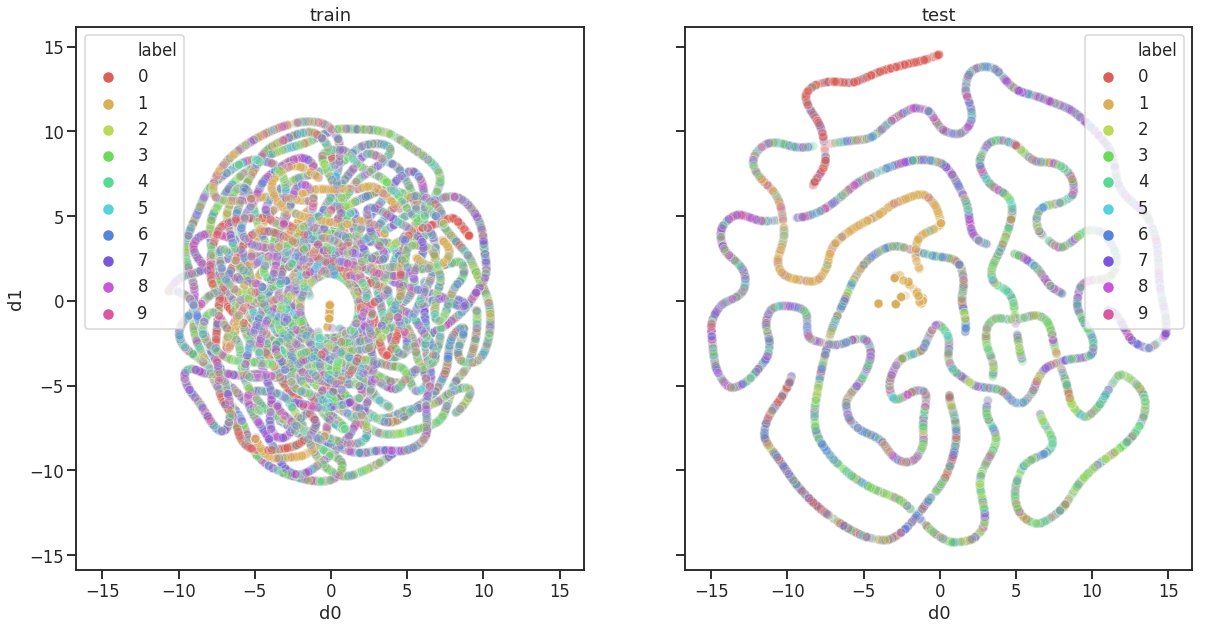

In [21]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 10))
for axi, title, pca_output, y in zip(
    ax, ["train", "test"], [tsne_train, tsne_test], [y_train, y_test]
): 
  sns.scatterplot(
      x="d0", y="d1",
      hue="label",
      palette=sns.color_palette("hls", 10),
      data=pd.DataFrame({
          "d0": pca_output[:, 0],
          "d1": pca_output[:, 1],
          "label": y
      }),
      legend="full",
      alpha=0.3,
      ax=axi
  )
  axi.set_title(title)

In [0]:
from IPython.display import Image, display, HTML

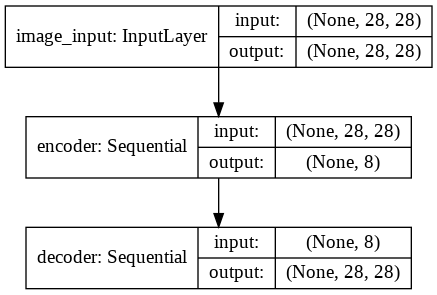

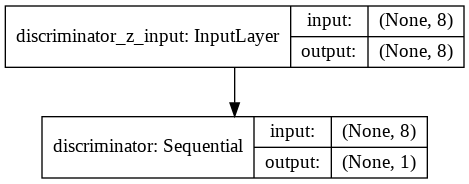

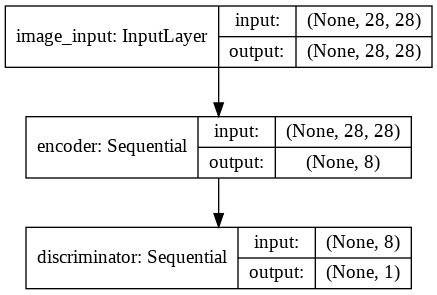

In [28]:
for name in ann.model_names:
  display(HTML(f"<h1>{name}</h1>"))
  display(Image(f"./{name}.png"))